In [53]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load data from database
db_path = r'C:\Users\kiran\Priya_Textile_DB.db'
table_name = 'PriyaTextile_FY23_24_ABC_XYZ_Data'

conn = sqlite3.connect(db_path)
query = f"""
SELECT 
    Product_code, 
    Month_ID, 
    SUM(Quantity) AS Quantity, 
    SUM(Value) AS Value  
FROM {table_name}
WHERE ABC_Category='A' and Month_ID <> 202506
GROUP BY Product_code, Month_ID
ORDER BY Product_code, Month_ID
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Convert Month_ID to datetime for future month computation
df['Month_ID'] = pd.to_datetime(df['Month_ID'].astype(str), format='%Y%m')

# Compute lag features
for lag in range(1, 25):
    df[f'lag_{lag}'] = df.groupby('Product_code')['Quantity'].shift(lag)

# --- Step: Add future row (Month_ID + 1 month globally) ---
next_month = df['Month_ID'].max() + pd.DateOffset(months=1)
future_rows = []

for product in df['Product_code'].unique():
    latest = df[df['Product_code'] == product].sort_values(by='Month_ID', ascending=False).iloc[0]
    row = {'Product_code': product, 'Month_ID': next_month, 'Quantity': np.nan, 'Value': np.nan}
    for i in range(1, 24):
        row[f'lag_{i+1}'] = latest.get(f'lag_{i}', np.nan)
    row['lag_1'] = latest['Quantity']
    future_rows.append(row)

future_df = pd.DataFrame(future_rows)
df = pd.concat([df, future_df], ignore_index=True)

# Apply PCA
def apply_pca(df, lag_range, prefix):
    lag_cols = [f'lag_{i}' for i in lag_range]
    df_clean = df.dropna(subset=lag_cols).copy()
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df_clean[lag_cols])
    pca = PCA(n_components=0.80)
    principal_components = pca.fit_transform(scaled_values)
    pca_df = pd.DataFrame(principal_components,
                          columns=[f'{prefix}_pca_{i+1}' for i in range(principal_components.shape[1])],
                          index=df_clean.index)
    df_clean = pd.concat([df_clean, pca_df], axis=1)
    return df_clean

df_pca_24 = apply_pca(df, range(1, 25), 'pca24')
df_pca_12 = apply_pca(df, range(1, 13), 'pca12')
df_pca_6  = apply_pca(df, range(1, 7),  'pca6')
df_pca_3  = apply_pca(df, range(1, 4),  'pca3')

# Merge PCA into original dataframe
final_df = df.copy()
final_df = final_df.join(df_pca_24.filter(like='pca24', axis=1))
final_df = final_df.join(df_pca_12.filter(like='pca12', axis=1))
final_df = final_df.join(df_pca_6.filter(like='pca6', axis=1))
final_df = final_df.join(df_pca_3.filter(like='pca3', axis=1))

# TSN similarity
def compute_tsn_features(df, lags=24):
    lag_cols = [f'lag_{i}' for i in range(1, lags + 1)]
    df['TSN_similarity'] = np.nan  # Initialize

    for product in df['Product_code'].unique():
        product_df = df[df['Product_code'] == product].copy()
        product_df = product_df.sort_values(by='Month_ID').reset_index()

        for i in range(1, len(product_df)):
            current_idx = product_df.loc[i, 'index']
            prev_idx = product_df.loc[i - 1, 'index']

            current_vector = product_df.loc[i, lag_cols]
            prev_vector = product_df.loc[i - 1, lag_cols]

            if current_vector.isnull().any() or prev_vector.isnull().any():
                continue

            similarity = cosine_similarity(
                current_vector.values.reshape(1, -1),
                prev_vector.values.reshape(1, -1)
            )[0][0]

            df.at[current_idx, 'TSN_similarity'] = similarity

    return df

final_df = compute_tsn_features(final_df)

# Peak/down lag functions
def compute_peak_lag(df, window, col_name):
    df[col_name] = df[[f'lag_{i}' for i in range(1, window + 1)]].apply(
        lambda row: np.nan if row.isnull().any() else np.argmax(row.values) + 1, axis=1)
    return df

def compute_down_lag(df, window, col_name):
    df[col_name] = df[[f'lag_{i}' for i in range(1, window + 1)]].apply(
        lambda row: np.nan if row.isnull().any() else np.argmin(row.values) + 1, axis=1)
    return df

for window in [3, 6, 12, 24]:
    final_df = final_df.groupby('Product_code', group_keys=False).apply(
        lambda group: compute_peak_lag(group, window, f'peak_{window}m')
    )
    final_df = final_df.groupby('Product_code', group_keys=False).apply(
        lambda group: compute_down_lag(group, window, f'down_{window}m')
    )

# Latency labels
def label_latency(group, window, col_name, mode='above'):
    labels = []
    for idx, row in group.iterrows():
        lags = [row.get(f'lag_{i}') for i in range(1, window + 1)]
        if any(pd.isnull(lags)):
            labels.append(np.nan)
            continue
        avg_val = np.mean(lags)
        latency = None
        for i in range(1, window + 1):
            if (mode == 'above' and row[f'lag_{i}'] > avg_val) or (mode == 'below' and row[f'lag_{i}'] < avg_val):
                latency = i
                break
        if latency is None:
            labels.append(0)  # No above/below avg
        elif latency <= 3:
            labels.append(1)  # <= 3 months
        else:
            labels.append(2)  # > 3 months
    group[col_name] = labels
    return group
    
for w in [3, 6, 12, 24]:
    final_df = final_df.groupby("Product_code", group_keys=False).apply(
        lambda g: label_latency(g, w, f'above_avg_{w}m_label', 'above')
    )
    final_df = final_df.groupby("Product_code", group_keys=False).apply(
        lambda g: label_latency(g, w, f'below_avg_{w}m_label', 'below')
    )

final_df = final_df.sort_values(by=['Product_code', 'Month_ID'])
for window in [3, 6, 12, 24]:
    final_df[f'rolling_avg_{window}'] = final_df.groupby('Product_code')['Quantity'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )

for span in [3, 6, 12, 24]:
    final_df[f'ewm_{span}'] = final_df.groupby('Product_code')['Quantity'].transform(
        lambda x: x.shift(1).ewm(span=span, adjust=False).mean()
    )

def apply_deviation_band(x):
    if pd.isnull(x):
        return np.nan
    elif x < 10:
        return 10
    elif x < 20:
        return 15
    else:
        return 25

for window in [3, 6, 12, 24]:
    # Rolling average
    final_df[f'Avg_{window}M'] = final_df.groupby('Product_code')['Quantity']\
                             .transform(lambda x: x.shift(1).rolling(window).mean())
    
    # Raw % deviation
    final_df[f'Dev_{window}M_%'] = ((final_df['Quantity'] - final_df[f'Avg_{window}M']) / final_df[f'Avg_{window}M']).abs() * 100

    # Apply banding to deviation %
    final_df[f'Dev_{window}M_%'] = final_df[f'Dev_{window}M_%'].apply(apply_deviation_band)

final_df['Prev_Quantity'] = final_df.groupby('Product_code')['Quantity'].shift(1)
final_df['Prev_Dev_3M'] = final_df.groupby('Product_code')['Dev_3M_%'].shift(1)
final_df['Prev_Dev_6M'] = final_df.groupby('Product_code')['Dev_6M_%'].shift(1)
final_df['Prev_Dev_12M'] = final_df.groupby('Product_code')['Dev_12M_%'].shift(1)
final_df['Prev_Dev_24M'] = final_df.groupby('Product_code')['Dev_24M_%'].shift(1)

# Calculate adjusted quantities using previous month quantity and deviation %
final_df['AdjQty_3M'] = final_df['Prev_Quantity'] * (1 + final_df['Prev_Dev_3M'] / 100)
final_df['AdjQty_6M'] = final_df['Prev_Quantity'] * (1 + final_df['Prev_Dev_6M'] / 100)
final_df['AdjQty_12M'] = final_df['Prev_Quantity'] * (1 + final_df['Prev_Dev_12M'] / 100)
final_df['AdjQty_24M'] = final_df['Prev_Quantity'] * (1 + final_df['Prev_Dev_24M'] / 100)

In [55]:
output_path = 'Final_out_With_All_Features.xlsx'
final_df.to_excel(output_path, index=False)

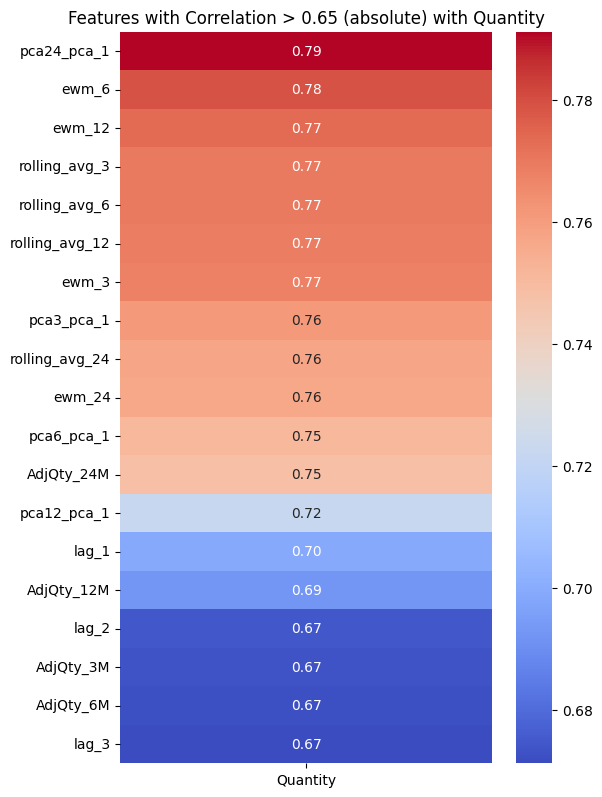

Features with |correlation| > 0.65 with Quantity:

pca24_pca_1       0.791161
ewm_6             0.779042
ewm_12            0.773686
rolling_avg_3     0.769840
rolling_avg_6     0.769669
rolling_avg_12    0.768712
ewm_3             0.767809
pca3_pca_1        0.761043
rolling_avg_24    0.757904
ewm_24            0.756869
pca6_pca_1        0.751263
AdjQty_24M        0.748487
pca12_pca_1       0.722210
lag_1             0.698948
AdjQty_12M        0.692758
lag_2             0.674462
AdjQty_3M         0.673456
AdjQty_6M         0.672663
lag_3             0.671286
Name: Quantity, dtype: float64


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_excel("Final_out_With_All_Features.xlsx")
df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

# Step 2: Filter training data
train_df = df[df['Month_ID'] <= pd.to_datetime("2025-03-01")]

# Step 3: Define feature columns
feature_cols = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
    'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
    'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
    'lag_23', 'lag_24',
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'TSN_similarity',
    'peak_3m', 'down_3m', 'peak_6m', 'down_6m',
    'peak_12m', 'down_12m', 'peak_24m', 'down_24m',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3',	'ewm_6'	,'ewm_12'	,'ewm_24'
]

# Step 4: Correlation with Quantity
corr_matrix = train_df[feature_cols + ['Quantity']].corr()
quantity_corr = corr_matrix['Quantity'].drop('Quantity')

# Step 5: Filter features with correlation > 0.65 or < -0.65
strong_corr = quantity_corr[quantity_corr.abs() > 0.65].sort_values(ascending=False)

# Step 6: Plot heatmap
plt.figure(figsize=(6, len(strong_corr) * 0.5))
sns.heatmap(strong_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Features with Correlation > 0.65 (absolute) with Quantity")
plt.show()

# Step 7: Optional - Print selected features
print("Features with |correlation| > 0.65 with Quantity:\n")
print(strong_corr)


## Mar 2025

In [63]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-03-01"
TRAIN_END_MONTH = "2025-02-01"

feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

OUT_OVERALL = "Model_Comparison_MAPE_Mar2025.xlsx"
OUT_ALLMODEL_PRED = "Mar2025_AllModel_Predictions.xlsx"
OUT_PRODUCT_BEST = "Product_BestModel_Mar2025.xlsx"
OUT_PRODUCT_WIDE_MAPE = "Product_Wise_MAPE_AllModels_Mar2025.xlsx"

def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

print("Loading data...")
df = pd.read_excel(DATA_PATH)

if 'Month_ID' not in df.columns:
    raise ValueError("Expected 'Month_ID' column in data.")

df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

train_df = df[df['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)].copy()
score_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

if score_df.empty:
    raise ValueError(f"No rows found for target month {TARGET_MONTH}. Check your data.")

train_df, score_df = encode_categoricals(train_df, score_df, feature_cols)

train_df = ensure_numeric(train_df, feature_cols, fill_value=0)
score_df = ensure_numeric(score_df, feature_cols, fill_value=0)

X_train = train_df[feature_cols]
y_train = train_df['Quantity']
X_score = score_df[feature_cols]
y_score_actual = score_df['Quantity'].values

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, iterations=100, depth=10, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

overall_results = []
score_df_models = score_df.copy()

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_score)
    score_df_models[f'{name}_Predicted'] = preds
    mape_val = safe_mape(y_score_actual, preds)
    overall_results.append({"Model": name, "Overall MAPE": round(mape_val, 2)})

results_df = pd.DataFrame(overall_results).sort_values('Overall MAPE')
results_df.to_excel(OUT_OVERALL, index=False)
print(f"\n📈 Overall MAPE exported to: {OUT_OVERALL}")
print(results_df)

product_mape_frames = []

for name in models.keys():
    rows = []
    pred_col = f'{name}_Predicted'
    for prod, g in score_df_models.groupby('Product_code'):
        mape_val = safe_mape(g['Quantity'], g[pred_col])
        rows.append({"Product_code": prod, f'{name}_MAPE': round(mape_val, 2)})
    product_mape_frames.append(pd.DataFrame(rows))

from functools import reduce
product_mape_wide = reduce(lambda left, right: pd.merge(left, right, on='Product_code'), product_mape_frames)
product_mape_wide.to_excel(OUT_PRODUCT_WIDE_MAPE, index=False)
print(f"📊 Product-wise MAPE (all models) exported to: {OUT_PRODUCT_WIDE_MAPE}")

melt_cols = [c for c in product_mape_wide.columns if c.endswith('_MAPE')]
product_mape_long = product_mape_wide.melt(id_vars='Product_code', value_vars=melt_cols,
                                           var_name='Model_MAPE_Col', value_name='MAPE')
product_mape_long['Model'] = product_mape_long['Model_MAPE_Col'].str.replace('_MAPE', '', regex=False)

idx = product_mape_long.groupby('Product_code')['MAPE'].idxmin()
product_best = product_mape_long.loc[idx, ['Product_code', 'Model', 'MAPE']].reset_index(drop=True)
product_best.rename(columns={'Model': 'Best_Model', 'MAPE': 'Best_MAPE'}, inplace=True)

agg_dict = {c: 'mean' for c in score_df_models.columns if c.endswith('_Predicted')}
agg_dict['Quantity'] = 'mean'
agg_dict['Month_ID'] = 'first'
agg_df = score_df_models.groupby('Product_code').agg(agg_dict).reset_index()

agg_df['Best_Prediction'] = np.nan
for i, row in product_best.iterrows():
    prod = row['Product_code']
    best_model = row['Best_Model']
    pred_col = f'{best_model}_Predicted'
    val = agg_df.loc[agg_df['Product_code'] == prod, pred_col]
    if not val.empty:
        agg_df.loc[agg_df['Product_code'] == prod, 'Best_Prediction'] = val.values[0]

product_best_full = pd.merge(agg_df, product_best, on='Product_code', how='left')

recalc_mapes = []
for i, r in product_best_full.iterrows():
    actual = r['Quantity']
    best_model = r['Best_Model']
    pred = r[f'{best_model}_Predicted'] if pd.notna(best_model) else np.nan
    recalc_mapes.append(safe_mape([actual], [pred]) if pd.notna(pred) else np.nan)
product_best_full['Best_MAPE_Recalc'] = np.round(recalc_mapes, 2)

final_cols = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE', 'Best_MAPE_Recalc']
final_cols = [c for c in final_cols if c in product_best_full.columns]
product_best_full_out = product_best_full[final_cols].copy()

if 'Best_MAPE_Recalc' in product_best_full_out.columns:
    product_best_full_out['Best_MAPE_Final'] = product_best_full_out['Best_MAPE_Recalc'].combine_first(product_best_full_out.get('Best_MAPE'))
    cols_order = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE_Final']
    product_best_full_out = product_best_full_out[cols_order]

product_best_full_out.to_excel(OUT_PRODUCT_BEST, index=False)
print(f"🏆 Best model per product exported to: {OUT_PRODUCT_BEST}")

export_cols = ['Product_code', 'Month_ID', 'Quantity'] + [f'{m}_Predicted' for m in models.keys()]
score_df_models[export_cols].to_excel(OUT_ALLMODEL_PRED, index=False)
print(f"✅ Detailed March predictions (all models) exported to: {OUT_ALLMODEL_PRED}")

print("\nAll done!")


Loading data...
Training LinearRegression...
Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7192
[LightGBM] [Info] Number of data points in the train set: 1383, number of used features: 30
[LightGBM] [Info] Start training from score 2397.123253

📈 Overall MAPE exported to: Model_Comparison_MAPE_Mar2025.xlsx
              Model  Overall MAPE
0  LinearRegression       1262.72
3          CatBoost       2070.86
2           XGBoost       2080.49
1      RandomForest       2179.02
4          LightGBM       2214.16
📊 Product-wise MAPE (all models) exported to: Product_Wise_MAPE_AllModels_Mar2025.xlsx
🏆 Best model per product exported to: Product_BestModel_Mar2025.xlsx
✅ Detailed March predictions (all models) exported to: Mar2025_AllModel_Predictions.xlsx

All done!


## April 2025

In [65]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-04-01"
TRAIN_END_MONTH = "2025-03-01"

feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

OUT_OVERALL = "Model_Comparison_MAPE_Apr2025.xlsx"
OUT_ALLMODEL_PRED = "Apr2025_AllModel_Predictions.xlsx"
OUT_PRODUCT_BEST = "Product_BestModel_Apr2025.xlsx"
OUT_PRODUCT_WIDE_MAPE = "Product_Wise_MAPE_AllModels_Apr2025.xlsx"

def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

print("Loading data...")
df = pd.read_excel(DATA_PATH)

if 'Month_ID' not in df.columns:
    raise ValueError("Expected 'Month_ID' column in data.")

df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

train_df = df[df['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)].copy()
score_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

if score_df.empty:
    raise ValueError(f"No rows found for target month {TARGET_MONTH}. Check your data.")

train_df, score_df = encode_categoricals(train_df, score_df, feature_cols)

train_df = ensure_numeric(train_df, feature_cols, fill_value=0)
score_df = ensure_numeric(score_df, feature_cols, fill_value=0)

X_train = train_df[feature_cols]
y_train = train_df['Quantity']
X_score = score_df[feature_cols]
y_score_actual = score_df['Quantity'].values

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, iterations=100, depth=10, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

overall_results = []
score_df_models = score_df.copy()

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_score)
    score_df_models[f'{name}_Predicted'] = preds
    mape_val = safe_mape(y_score_actual, preds)
    overall_results.append({"Model": name, "Overall MAPE": round(mape_val, 2)})

results_df = pd.DataFrame(overall_results).sort_values('Overall MAPE')
results_df.to_excel(OUT_OVERALL, index=False)
print(f"\n📈 Overall MAPE exported to: {OUT_OVERALL}")
print(results_df)

product_mape_frames = []

for name in models.keys():
    rows = []
    pred_col = f'{name}_Predicted'
    for prod, g in score_df_models.groupby('Product_code'):
        mape_val = safe_mape(g['Quantity'], g[pred_col])
        rows.append({"Product_code": prod, f'{name}_MAPE': round(mape_val, 2)})
    product_mape_frames.append(pd.DataFrame(rows))

from functools import reduce
product_mape_wide = reduce(lambda left, right: pd.merge(left, right, on='Product_code'), product_mape_frames)
product_mape_wide.to_excel(OUT_PRODUCT_WIDE_MAPE, index=False)
print(f"📊 Product-wise MAPE (all models) exported to: {OUT_PRODUCT_WIDE_MAPE}")

melt_cols = [c for c in product_mape_wide.columns if c.endswith('_MAPE')]
product_mape_long = product_mape_wide.melt(id_vars='Product_code', value_vars=melt_cols,
                                           var_name='Model_MAPE_Col', value_name='MAPE')
product_mape_long['Model'] = product_mape_long['Model_MAPE_Col'].str.replace('_MAPE', '', regex=False)

idx = product_mape_long.groupby('Product_code')['MAPE'].idxmin()
product_best = product_mape_long.loc[idx, ['Product_code', 'Model', 'MAPE']].reset_index(drop=True)
product_best.rename(columns={'Model': 'Best_Model', 'MAPE': 'Best_MAPE'}, inplace=True)

agg_dict = {c: 'mean' for c in score_df_models.columns if c.endswith('_Predicted')}
agg_dict['Quantity'] = 'mean'
agg_dict['Month_ID'] = 'first'
agg_df = score_df_models.groupby('Product_code').agg(agg_dict).reset_index()

agg_df['Best_Prediction'] = np.nan
for i, row in product_best.iterrows():
    prod = row['Product_code']
    best_model = row['Best_Model']
    pred_col = f'{best_model}_Predicted'
    val = agg_df.loc[agg_df['Product_code'] == prod, pred_col]
    if not val.empty:
        agg_df.loc[agg_df['Product_code'] == prod, 'Best_Prediction'] = val.values[0]

product_best_full = pd.merge(agg_df, product_best, on='Product_code', how='left')

recalc_mapes = []
for i, r in product_best_full.iterrows():
    actual = r['Quantity']
    best_model = r['Best_Model']
    pred = r[f'{best_model}_Predicted'] if pd.notna(best_model) else np.nan
    recalc_mapes.append(safe_mape([actual], [pred]) if pd.notna(pred) else np.nan)
product_best_full['Best_MAPE_Recalc'] = np.round(recalc_mapes, 2)

final_cols = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE', 'Best_MAPE_Recalc']
final_cols = [c for c in final_cols if c in product_best_full.columns]
product_best_full_out = product_best_full[final_cols].copy()

if 'Best_MAPE_Recalc' in product_best_full_out.columns:
    product_best_full_out['Best_MAPE_Final'] = product_best_full_out['Best_MAPE_Recalc'].combine_first(product_best_full_out.get('Best_MAPE'))
    cols_order = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE_Final']
    product_best_full_out = product_best_full_out[cols_order]

product_best_full_out.to_excel(OUT_PRODUCT_BEST, index=False)
print(f"🏆 Best model per product exported to: {OUT_PRODUCT_BEST}")

export_cols = ['Product_code', 'Month_ID', 'Quantity'] + [f'{m}_Predicted' for m in models.keys()]
score_df_models[export_cols].to_excel(OUT_ALLMODEL_PRED, index=False)
print(f"✅ Detailed March predictions (all models) exported to: {OUT_ALLMODEL_PRED}")

print("\nAll done!")


Loading data...
Training LinearRegression...
Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7280
[LightGBM] [Info] Number of data points in the train set: 1412, number of used features: 30
[LightGBM] [Info] Start training from score 2403.649227

📈 Overall MAPE exported to: Model_Comparison_MAPE_Apr2025.xlsx
              Model  Overall MAPE
1      RandomForest        140.42
2           XGBoost        151.96
3          CatBoost        158.74
0  LinearRegression        171.33
4          LightGBM        172.89
📊 Product-wise MAPE (all models) exported to: Product_Wise_MAPE_AllModels_Apr2025.xlsx
🏆 Best model per product exported to: Product_BestModel_Apr2025.xlsx
✅ Detailed March predictions (all models) exported to: Apr2025_AllModel_Predictions.xlsx

All done!


## May 2025

In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-05-01"
TRAIN_END_MONTH = "2025-04-01"

feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

OUT_OVERALL = "Model_Comparison_MAPE_May2025.xlsx"
OUT_ALLMODEL_PRED = "May2025_AllModel_Predictions.xlsx"
OUT_PRODUCT_BEST = "Product_BestModel_May2025.xlsx"
OUT_PRODUCT_WIDE_MAPE = "Product_Wise_MAPE_AllModels_May2025.xlsx"

def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

print("Loading data...")
df = pd.read_excel(DATA_PATH)

if 'Month_ID' not in df.columns:
    raise ValueError("Expected 'Month_ID' column in data.")

df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

train_df = df[df['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)].copy()
score_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

if score_df.empty:
    raise ValueError(f"No rows found for target month {TARGET_MONTH}. Check your data.")

train_df, score_df = encode_categoricals(train_df, score_df, feature_cols)

train_df = ensure_numeric(train_df, feature_cols, fill_value=0)
score_df = ensure_numeric(score_df, feature_cols, fill_value=0)

X_train = train_df[feature_cols]
y_train = train_df['Quantity']
X_score = score_df[feature_cols]
y_score_actual = score_df['Quantity'].values

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, iterations=100, depth=10, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

overall_results = []
score_df_models = score_df.copy()

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_score)
    score_df_models[f'{name}_Predicted'] = preds
    mape_val = safe_mape(y_score_actual, preds)
    overall_results.append({"Model": name, "Overall MAPE": round(mape_val, 2)})

results_df = pd.DataFrame(overall_results).sort_values('Overall MAPE')
results_df.to_excel(OUT_OVERALL, index=False)
print(f"\n📈 Overall MAPE exported to: {OUT_OVERALL}")
print(results_df)

product_mape_frames = []

for name in models.keys():
    rows = []
    pred_col = f'{name}_Predicted'
    for prod, g in score_df_models.groupby('Product_code'):
        mape_val = safe_mape(g['Quantity'], g[pred_col])
        rows.append({"Product_code": prod, f'{name}_MAPE': round(mape_val, 2)})
    product_mape_frames.append(pd.DataFrame(rows))

from functools import reduce
product_mape_wide = reduce(lambda left, right: pd.merge(left, right, on='Product_code'), product_mape_frames)
product_mape_wide.to_excel(OUT_PRODUCT_WIDE_MAPE, index=False)
print(f"📊 Product-wise MAPE (all models) exported to: {OUT_PRODUCT_WIDE_MAPE}")

melt_cols = [c for c in product_mape_wide.columns if c.endswith('_MAPE')]
product_mape_long = product_mape_wide.melt(id_vars='Product_code', value_vars=melt_cols,
                                           var_name='Model_MAPE_Col', value_name='MAPE')
product_mape_long['Model'] = product_mape_long['Model_MAPE_Col'].str.replace('_MAPE', '', regex=False)

idx = product_mape_long.groupby('Product_code')['MAPE'].idxmin()
product_best = product_mape_long.loc[idx, ['Product_code', 'Model', 'MAPE']].reset_index(drop=True)
product_best.rename(columns={'Model': 'Best_Model', 'MAPE': 'Best_MAPE'}, inplace=True)

agg_dict = {c: 'mean' for c in score_df_models.columns if c.endswith('_Predicted')}
agg_dict['Quantity'] = 'mean'
agg_dict['Month_ID'] = 'first'
agg_df = score_df_models.groupby('Product_code').agg(agg_dict).reset_index()

agg_df['Best_Prediction'] = np.nan
for i, row in product_best.iterrows():
    prod = row['Product_code']
    best_model = row['Best_Model']
    pred_col = f'{best_model}_Predicted'
    val = agg_df.loc[agg_df['Product_code'] == prod, pred_col]
    if not val.empty:
        agg_df.loc[agg_df['Product_code'] == prod, 'Best_Prediction'] = val.values[0]

product_best_full = pd.merge(agg_df, product_best, on='Product_code', how='left')

recalc_mapes = []
for i, r in product_best_full.iterrows():
    actual = r['Quantity']
    best_model = r['Best_Model']
    pred = r[f'{best_model}_Predicted'] if pd.notna(best_model) else np.nan
    recalc_mapes.append(safe_mape([actual], [pred]) if pd.notna(pred) else np.nan)
product_best_full['Best_MAPE_Recalc'] = np.round(recalc_mapes, 2)

final_cols = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE', 'Best_MAPE_Recalc']
final_cols = [c for c in final_cols if c in product_best_full.columns]
product_best_full_out = product_best_full[final_cols].copy()

if 'Best_MAPE_Recalc' in product_best_full_out.columns:
    product_best_full_out['Best_MAPE_Final'] = product_best_full_out['Best_MAPE_Recalc'].combine_first(product_best_full_out.get('Best_MAPE'))
    cols_order = ['Product_code', 'Month_ID', 'Quantity', 'Best_Model', 'Best_Prediction', 'Best_MAPE_Final']
    product_best_full_out = product_best_full_out[cols_order]

product_best_full_out.to_excel(OUT_PRODUCT_BEST, index=False)
print(f"🏆 Best model per product exported to: {OUT_PRODUCT_BEST}")

export_cols = ['Product_code', 'Month_ID', 'Quantity'] + [f'{m}_Predicted' for m in models.keys()]
score_df_models[export_cols].to_excel(OUT_ALLMODEL_PRED, index=False)
print(f"✅ Detailed March predictions (all models) exported to: {OUT_ALLMODEL_PRED}")

print("\nAll done!")


Loading data...
Training LinearRegression...
Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7363
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 30
[LightGBM] [Info] Start training from score 2400.210207

📈 Overall MAPE exported to: Model_Comparison_MAPE_May2025.xlsx
              Model  Overall MAPE
0  LinearRegression         75.40
3          CatBoost         76.62
1      RandomForest         79.06
4          LightGBM         80.47
2           XGBoost         83.28
📊 Product-wise MAPE (all models) exported to: Product_Wise_MAPE_AllModels_May2025.xlsx
🏆 Best model per product exported to: Product_BestModel_May2025.xlsx
✅ Detailed March predictions (all models) exported to: May2025_AllModel_Predictions.xlsx

All done!


In [16]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from functools import reduce

warnings.filterwarnings("ignore")

# File paths
DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-05-01"
TRAIN_END_MONTH = "2025-04-01"
OUT_OVERALL = "Model_Comparison_MAPE_May2025.xlsx"
OUT_ALLMODEL_PRED = "May2025_AllModel_Predictions.xlsx"
OUT_PRODUCT_BEST = "Product_BestModel_May2025.xlsx"
OUT_PRODUCT_WIDE_MAPE = "Product_Wise_MAPE_AllModels_May2025.xlsx"
OUT_ACTUAL_PREDICTED = "Actual_vs_Predicted_Per_Product.xlsx"

# Feature columns
feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

# Functions
def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

# Load data
print("🔄 Loading data...")
df = pd.read_excel(DATA_PATH)
df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

train_df = df[df['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)].copy()
score_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

if score_df.empty:
    raise ValueError(f"No rows found for target month {TARGET_MONTH}.")

# Preprocessing
train_df, score_df = encode_categoricals(train_df, score_df, feature_cols)
train_df = ensure_numeric(train_df, feature_cols)
score_df = ensure_numeric(score_df, feature_cols)

X_train = train_df[feature_cols]
y_train = train_df['Quantity']
X_score = score_df[feature_cols]
y_score_actual = score_df['Quantity'].values

# Models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, iterations=100, depth=10, learning_rate=0.1, random_state=42,verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42,verbose=-1)
}

# Train & predict
overall_results = []
score_df_models = score_df.copy()

for name, model in models.items():
    print(f"🤖 Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_score)
    score_df_models[f'{name}_Predicted'] = preds
    mape_val = safe_mape(y_score_actual, preds)
    overall_results.append({"Model": name, "Overall MAPE": round(mape_val, 2)})

results_df = pd.DataFrame(overall_results).sort_values('Overall MAPE')
results_df.to_excel(OUT_OVERALL, index=False)
print(f"📈 Overall MAPE saved to: {OUT_OVERALL}")

# Product-wise MAPE
product_mape_frames = []
for name in models.keys():
    rows = []
    pred_col = f'{name}_Predicted'
    for prod, g in score_df_models.groupby('Product_code'):
        mape_val = safe_mape(g['Quantity'], g[pred_col])
        rows.append({"Product_code": prod, f'{name}_MAPE': round(mape_val, 2)})
    product_mape_frames.append(pd.DataFrame(rows))

product_mape_wide = reduce(lambda left, right: pd.merge(left, right, on='Product_code'), product_mape_frames)
product_mape_wide.to_excel(OUT_PRODUCT_WIDE_MAPE, index=False)
print(f"📊 Product-wise MAPE saved to: {OUT_PRODUCT_WIDE_MAPE}")

# Best model per product
melt_cols = [c for c in product_mape_wide.columns if c.endswith('_MAPE')]
product_mape_long = product_mape_wide.melt(id_vars='Product_code', value_vars=melt_cols,
                                           var_name='Model_MAPE_Col', value_name='MAPE')
product_mape_long['Model'] = product_mape_long['Model_MAPE_Col'].str.replace('_MAPE', '', regex=False)
idx = product_mape_long.groupby('Product_code')['MAPE'].idxmin()
product_best = product_mape_long.loc[idx, ['Product_code', 'Model', 'MAPE']].reset_index(drop=True)
product_best.rename(columns={'Model': 'Best_Model', 'MAPE': 'Best_MAPE'}, inplace=True)

# Merge predictions
agg_dict = {c: 'mean' for c in score_df_models.columns if c.endswith('_Predicted')}
agg_dict['Quantity'] = 'mean'
agg_dict['Month_ID'] = 'first'
agg_df = score_df_models.groupby('Product_code').agg(agg_dict).reset_index()

agg_df['Best_Prediction'] = np.nan
for i, row in product_best.iterrows():
    prod = row['Product_code']
    best_model = row['Best_Model']
    pred_col = f'{best_model}_Predicted'
    val = agg_df.loc[agg_df['Product_code'] == prod, pred_col]
    if not val.empty:
        agg_df.loc[agg_df['Product_code'] == prod, 'Best_Prediction'] = val.values[0]

product_best_full = pd.merge(agg_df, product_best, on='Product_code', how='left')

# Recalculate MAPE
product_best_full['Best_MAPE_Recalc'] = product_best_full.apply(
    lambda r: safe_mape([r['Quantity']], [r[f"{r['Best_Model']}_Predicted"]]) if pd.notna(r['Best_Model']) else np.nan,
    axis=1
)

product_best_full_out = product_best_full[['Product_code', 'Month_ID', 'Quantity', 'Best_Model',
                                           'Best_Prediction', 'Best_MAPE_Recalc']]
product_best_full_out['Best_MAPE_Final'] = product_best_full_out['Best_MAPE_Recalc']

product_best_full_out.to_excel(OUT_PRODUCT_BEST, index=False)
print(f"🏆 Best models per product saved to: {OUT_PRODUCT_BEST}")

# Actual vs Predicted export
comparison_df = product_best_full_out.rename(columns={
    'Quantity': 'Actual_Quantity',
    'Best_Prediction': 'Predicted_Quantity',
    'Best_Model': 'Model_Used'
})
comparison_df['Abs_Error'] = np.abs(comparison_df['Actual_Quantity'] - comparison_df['Predicted_Quantity'])
comparison_df['Perc_Error'] = np.round((comparison_df['Abs_Error'] / (comparison_df['Actual_Quantity'] + 1e-9)) * 100, 2)
comparison_df.to_excel(OUT_ACTUAL_PREDICTED, index=False)
print(f"📉 Actual vs Predicted per product saved to: {OUT_ACTUAL_PREDICTED}")

# Export all model predictions
export_cols = ['Product_code', 'Month_ID', 'Quantity'] + [f'{m}_Predicted' for m in models.keys()]
score_df_models[export_cols].to_excel(OUT_ALLMODEL_PRED, index=False)
print(f"✅ All model predictions saved to: {OUT_ALLMODEL_PRED}")

# 🔍 Line plots for low-MAPE products over last 6 months
low_mape_products = product_best_full_out[product_best_full_out['Best_MAPE_Final'] < 20]['Product_code'].unique()
last_6_months = pd.date_range(end=pd.to_datetime(TARGET_MONTH), periods=6, freq='MS')

plot_df = df[df['Product_code'].isin(low_mape_products) & df['Month_ID'].isin(last_6_months)].copy()
plot_df = ensure_numeric(plot_df, feature_cols)
plot_df, _ = encode_categoricals(plot_df, plot_df, feature_cols)

print(f"\n📌 Generating line plots for {len(low_mape_products)} low-MAPE products...")

for prod in low_mape_products:
    model_name = product_best_full_out.loc[product_best_full_out['Product_code'] == prod, 'Best_Model'].values[0]
    model = models[model_name]

    df_prod = plot_df[plot_df['Product_code'] == prod].copy()
    df_prod.sort_values('Month_ID', inplace=True)

    X_prod = df_prod[feature_cols]
    y_actual = df_prod['Quantity'].values
    y_pred = model.predict(X_prod)

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(df_prod['Month_ID'], y_actual, label='Actual', marker='o', linestyle='-')
    plt.plot(df_prod['Month_ID'], y_pred, label='Predicted', marker='x', linestyle='--')
    plt.title(f'Actual vs Predicted for Product {prod} (Last 6 Months)')
    plt.xlabel('Month')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"LinePlot_Product_{prod}.png")
    plt.close()
    print(f"📈 Plot saved: LinePlot_Product_{prod}.png")

print("\n✅ All tasks completed successfully!")


🔄 Loading data...
🤖 Training LinearRegression...
🤖 Training RandomForest...
🤖 Training XGBoost...
🤖 Training CatBoost...
🤖 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7363
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 30
[LightGBM] [Info] Start training from score 2400.210207
📈 Overall MAPE saved to: Model_Comparison_MAPE_May2025.xlsx
📊 Product-wise MAPE saved to: Product_Wise_MAPE_AllModels_May2025.xlsx
🏆 Best models per product saved to: Product_BestModel_May2025.xlsx
📉 Actual vs Predicted per product saved to: Actual_vs_Predicted_Per_Product.xlsx
✅ All model predictions saved to: May2025_AllModel_Predictions.xlsx

📌 Generating line plots for 12 low-MAPE products...
📈 Plot saved: LinePlot_Product_144.png
📈 Plot saved: LinePlot_Product_187.png
📈 Plot saved: LinePlot_Product_223

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🎯 Filter top 12 products with MAPE < 20%
top_12_low_mape = product_best_full_out[product_best_full_out['Best_MAPE_Final'] < 20] \
                    .sort_values(by='Best_MAPE_Final') \
                    .head(12)

# 🧮 Compute MAE, MSE, MAPE for each
top_12_low_mape['MAE'] = abs(top_12_low_mape['Quantity'] - top_12_low_mape['Best_Prediction'])
top_12_low_mape['MSE'] = (top_12_low_mape['Quantity'] - top_12_low_mape['Best_Prediction']) ** 2
top_12_low_mape['MAPE (%)'] = top_12_low_mape['Best_MAPE_Final']  # Rename for clarity

# 📊 Show key metrics
print("\n🔝 Top 12 Products with MAPE < 20% (including MAE, MSE):")
print(top_12_low_mape[['Product_code', 'Best_Model', 'Quantity', 'Best_Prediction', 'MAE', 'MSE', 'MAPE (%)']])

# 💾 Save to Excel
top_12_low_mape.to_excel("Top12_Low_MAPE_Products_With_Metrics.xlsx", index=False)
print("📄 Saved to: Top12_Low_MAPE_Products_With_Metrics.xlsx")



🔝 Top 12 Products with MAPE < 20% (including MAE, MSE):
    Product_code        Best_Model  Quantity  Best_Prediction          MAE  \
10           237          CatBoost   1159.23      1150.412768     8.817232   
22           600          LightGBM    664.40       673.948248     9.548248   
25           661          LightGBM    663.69       653.672137    10.017863   
7            223          CatBoost   1367.16      1335.843355    31.316645   
0            144          LightGBM   3867.23      3737.694870   129.535130   
21           578          LightGBM   2089.80      2189.056451    99.256451   
17           495      RandomForest   4351.05      4578.665139   227.615139   
5            187          CatBoost   1600.00      1713.640775   113.640775   
28           706           XGBoost    456.70       492.810883    36.110883   
19           540  LinearRegression  10222.39      9175.830583  1046.559417   
8            232           XGBoost   1379.00      1534.147583   155.147583   
9      

## June 2025

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-06-01"
TRAIN_END_MONTH = "2025-05-01"
VALIDATION_MONTHS = ["2024-11-01","2024-12-01","2025-01-01","2025-02-01", "2025-03-01", "2025-04-01"]

feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

# ---------------------------------------------
# HELPERS
# ---------------------------------------------
def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

# ---------------------------------------------
# LOAD DATA
# ---------------------------------------------
df = pd.read_excel(DATA_PATH)
df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

# ---------------------------------------------
# DEFINE MODELS
# ---------------------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42,verbose=-1)
}

# ---------------------------------------------
# PRODUCT-WISE MODEL SELECTION
# ---------------------------------------------
product_best_models = {}

all_products = df['Product_code'].unique()

for product in all_products:
    df_prod = df[df['Product_code'] == product]
    df_prod = df_prod[df_prod['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)]

    model_mapes = {name: [] for name in models}
    
    for val_month in pd.to_datetime(VALIDATION_MONTHS):
        train_df = df_prod[df_prod['Month_ID'] < val_month]
        val_df = df_prod[df_prod['Month_ID'] == val_month]
        if train_df.empty or val_df.empty:
            continue

        train_df, val_df = encode_categoricals(train_df, val_df, feature_cols)
        train_df = ensure_numeric(train_df, feature_cols)
        val_df = ensure_numeric(val_df, feature_cols)

        X_train, y_train = train_df[feature_cols], train_df['Quantity']
        X_val, y_val = val_df[feature_cols], val_df['Quantity']

        for name, model in models.items():
            try:
                model.fit(X_train, y_train)
                preds = model.predict(X_val)
                mape = safe_mape(y_val, preds)
                model_mapes[name].append(mape)
            except:
                continue

    # Compute average MAPE
    avg_mapes = {name: np.mean(vals) if vals else np.inf for name, vals in model_mapes.items()}
    best_model = min(avg_mapes, key=avg_mapes.get)
    product_best_models[product] = best_model

print("✅ Best model selected for each product based on past MAPE.")

# ---------------------------------------------
# FINAL FORECAST USING BEST MODELS
# ---------------------------------------------
forecast_rows = []
forecast_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

for product in all_products:
    prod_df = df[(df['Product_code'] == product) & (df['Month_ID'] < pd.to_datetime(TARGET_MONTH))]
    test_df = forecast_df[forecast_df['Product_code'] == product]

    if prod_df.empty or test_df.empty:
        continue

    prod_df, test_df = encode_categoricals(prod_df, test_df, feature_cols)
    prod_df = ensure_numeric(prod_df, feature_cols)
    test_df = ensure_numeric(test_df, feature_cols)

    X_train, y_train = prod_df[feature_cols], prod_df['Quantity']
    X_test = test_df[feature_cols]

    model_name = product_best_models.get(product)
    if not model_name:
        continue

    model = models[model_name]
    try:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        for i in range(len(test_df)):
            forecast_rows.append({
                "Product_code": product,
                "Month_ID": TARGET_MONTH,
                "Predicted_Quantity": pred[i],
                "Model_Used": model_name
            })
    except:
        continue

# ---------------------------------------------
# EXPORT FINAL FORECAST
# ---------------------------------------------
forecast_output = pd.DataFrame(forecast_rows)
forecast_output.to_excel(f"Forecast_{TARGET_MONTH[:7]}_ProductWise_BestModels.xlsx", index=False)
print(f"\n📦 Final forecast saved to Forecast_{TARGET_MONTH[:7]}_ProductWise_BestModels.xlsx")


✅ Best model selected for each product based on past MAPE.

📦 Final forecast saved to Forecast_2025-06_ProductWise_BestModels.xlsx


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
DATA_PATH = "Final_out_With_All_Features.xlsx"
TARGET_MONTH = "2025-06-01"
TRAIN_END_MONTH = "2025-05-01"
VALIDATION_MONTHS = ["2024-11-01","2024-12-01","2025-01-01","2025-02-01", "2025-03-01", "2025-04-01"]

feature_cols = [
    'pca24_pca_1', 'pca24_pca_2', 'pca24_pca_3', 'pca24_pca_4',
    'pca24_pca_5', 'pca24_pca_6', 'pca24_pca_7', 'pca24_pca_8',
    'pca12_pca_1', 'pca12_pca_2', 'pca12_pca_3', 'pca12_pca_4', 'pca12_pca_5',
    'pca6_pca_1', 'pca6_pca_2', 'pca6_pca_3',
    'pca3_pca_1', 'pca3_pca_2',
    'rolling_avg_3', 'rolling_avg_6', 'rolling_avg_12', 'rolling_avg_24',
    'AdjQty_3M', 'AdjQty_6M', 'AdjQty_12M', 'AdjQty_24M',
    'ewm_3', 'ewm_6', 'ewm_12', 'ewm_24'
]

# ---------------------------------------------
# HELPERS
# ---------------------------------------------
def safe_mape(y_true, y_pred, epsilon=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def encode_categoricals(train_df, score_df, feature_cols):
    train_enc = train_df.copy()
    score_enc = score_df.copy()
    object_cols = train_enc[feature_cols].select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        le = LabelEncoder()
        combined = pd.concat([train_enc[col], score_enc[col]], axis=0).astype(str)
        le.fit(combined)
        train_enc[col] = le.transform(train_enc[col].astype(str))
        score_enc[col] = le.transform(score_enc[col].astype(str))
    return train_enc, score_enc

def ensure_numeric(df, cols, fill_value=0):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    out[cols] = out[cols].fillna(fill_value)
    return out

# ---------------------------------------------
# LOAD DATA
# ---------------------------------------------
df = pd.read_excel(DATA_PATH)
df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df.sort_values(by=['Product_code', 'Month_ID'], inplace=True)

# ---------------------------------------------
# DEFINE MODELS
# ---------------------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42,verbose=-1)
}

# ---------------------------------------------
# PRODUCT-WISE MODEL SELECTION + METRIC CAPTURE
# ---------------------------------------------
product_best_models = {}
validation_results = []

all_products = df['Product_code'].unique()

for product in all_products:
    df_prod = df[df['Product_code'] == product]
    df_prod = df_prod[df_prod['Month_ID'] <= pd.to_datetime(TRAIN_END_MONTH)]

    model_metrics = {name: {"MAPE": [], "MAE": [], "MSE": []} for name in models}

    for val_month in pd.to_datetime(VALIDATION_MONTHS):
        train_df = df_prod[df_prod['Month_ID'] < val_month]
        val_df = df_prod[df_prod['Month_ID'] == val_month]
        if train_df.empty or val_df.empty:
            continue

        train_df, val_df = encode_categoricals(train_df, val_df, feature_cols)
        train_df = ensure_numeric(train_df, feature_cols)
        val_df = ensure_numeric(val_df, feature_cols)

        X_train, y_train = train_df[feature_cols], train_df['Quantity']
        X_val, y_val = val_df[feature_cols], val_df['Quantity']

        for name, model in models.items():
            try:
                model.fit(X_train, y_train)
                preds = model.predict(X_val)

                mape = safe_mape(y_val, preds)
                mae = mean_absolute_error(y_val, preds)
                mse = mean_squared_error(y_val, preds)

                model_metrics[name]["MAPE"].append(mape)
                model_metrics[name]["MAE"].append(mae)
                model_metrics[name]["MSE"].append(mse)
            except Exception as e:
                continue

    avg_metrics = {
        name: {
            "MAPE": np.mean(vals["MAPE"]) if vals["MAPE"] else np.inf,
            "MAE": np.mean(vals["MAE"]) if vals["MAE"] else np.inf,
            "MSE": np.mean(vals["MSE"]) if vals["MSE"] else np.inf
        }
        for name, vals in model_metrics.items()
    }

    best_model = min(avg_metrics, key=lambda k: avg_metrics[k]["MAPE"])
    product_best_models[product] = best_model

    for model_name, metrics in avg_metrics.items():
        validation_results.append({
            "Product_code": product,
            "Model": model_name,
            "Avg_MAPE": metrics["MAPE"],
            "Avg_MAE": metrics["MAE"],
            "Avg_MSE": metrics["MSE"]
        })

print("✅ Validation complete. Best models and metrics recorded.")

# ---------------------------------------------
# FINAL FORECAST USING BEST MODELS
# ---------------------------------------------
forecast_rows = []
forecast_df = df[df['Month_ID'] == pd.to_datetime(TARGET_MONTH)].copy()

for product in all_products:
    prod_df = df[(df['Product_code'] == product) & (df['Month_ID'] < pd.to_datetime(TARGET_MONTH))]
    test_df = forecast_df[forecast_df['Product_code'] == product]

    if prod_df.empty or test_df.empty:
        continue

    prod_df, test_df = encode_categoricals(prod_df, test_df, feature_cols)
    prod_df = ensure_numeric(prod_df, feature_cols)
    test_df = ensure_numeric(test_df, feature_cols)

    X_train, y_train = prod_df[feature_cols], prod_df['Quantity']
    X_test = test_df[feature_cols]

    model_name = product_best_models.get(product)
    if not model_name:
        continue

    model = models[model_name]
    try:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        for i in range(len(test_df)):
            forecast_rows.append({
                "Product_code": product,
                "Month_ID": TARGET_MONTH,
                "Predicted_Quantity": pred[i],
                "Model_Used": model_name
            })
    except:
        continue

# ---------------------------------------------
# EXPORT FORECAST & METRICS
# ---------------------------------------------
forecast_output = pd.DataFrame(forecast_rows)
forecast_output.to_excel(f"Forecast_{TARGET_MONTH[:7]}_ProductWise_BestModels.xlsx", index=False)
print(f"\n📦 Forecast saved to Forecast_{TARGET_MONTH[:7]}_ProductWise_BestModels.xlsx")

validation_df = pd.DataFrame(validation_results)
validation_df.to_excel(f"Validation_Metrics_Per_Product_{TARGET_MONTH[:7]}.xlsx", index=False)
print(f"📊 Validation metrics saved to Validation_Metrics_Per_Product_{TARGET_MONTH[:7]}.xlsx")


✅ Validation complete. Best models and metrics recorded.

📦 Forecast saved to Forecast_2025-06_ProductWise_BestModels.xlsx
📊 Validation metrics saved to Validation_Metrics_Per_Product_2025-06.xlsx
